<a href="https://colab.research.google.com/github/Ciciliaparastita/Portofolio/blob/main/Mentoring_3_Fraud_Analytics_Cicilia_Parastita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset preparation

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression


# Load the dataset
df = pd.read_csv('fraud_ecom_transaction_data.csv')

#Check for missing values
missing_values = df.isnull().sum()

#Check for duplicate records
duplicates = df.duplicated().sum()

#Basic data overview for inconsistencies
overview = df.describe(include='all')

#Remove duplicates if any
df_cleaned = df.drop_duplicates()

# Handle missing values (simple strategy — can be customized)
df_cleaned = df_cleaned.dropna()

# Q1

In [32]:
# Define target and features
target = 'Is Fraudulent'
X = df_cleaned.drop(columns=[target, 'Transaction ID'])  # drop identifier and target
y = df_cleaned[target]

# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# Second split: 50% of temp goes to val, 50% to test (i.e., 20% each of original data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Missing values:\n{missing_values}")
print(f"Duplicate records: {duplicates}")
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")


Missing values:
Transaction ID        0
Transaction Amount    0
Payment Method        0
Product Category      0
Quantity              0
Customer Age          0
Device Used           0
Is Fraudulent         0
Account Age Days      0
Transaction Hour      0
dtype: int64
Duplicate records: 0
Training set size: (14180, 8)
Validation set size: (4727, 8)
Test set size: (4727, 8)


# Q2

## Histogram: Transaction Amount by Fraud Status

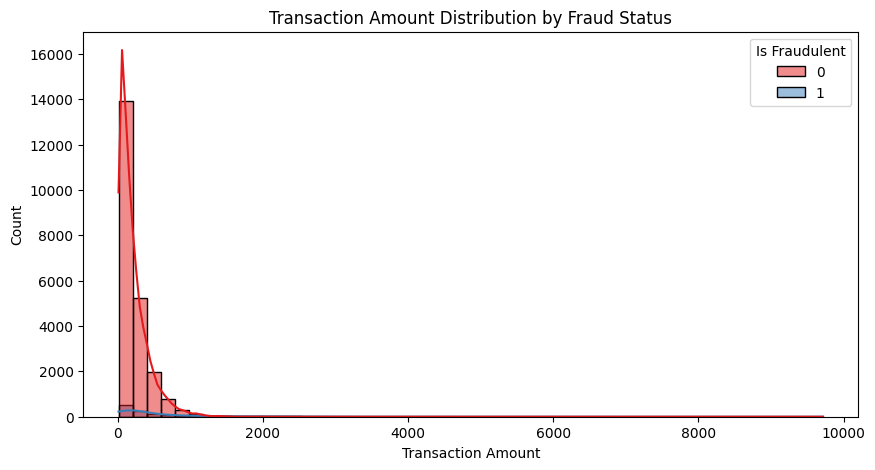

In [33]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_cleaned, x='Transaction Amount', hue='Is Fraudulent', bins=50, kde=True, palette='Set1')
plt.title('Transaction Amount Distribution by Fraud Status')
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.show()


## Histogram: Transaction Hour by Fraud Status

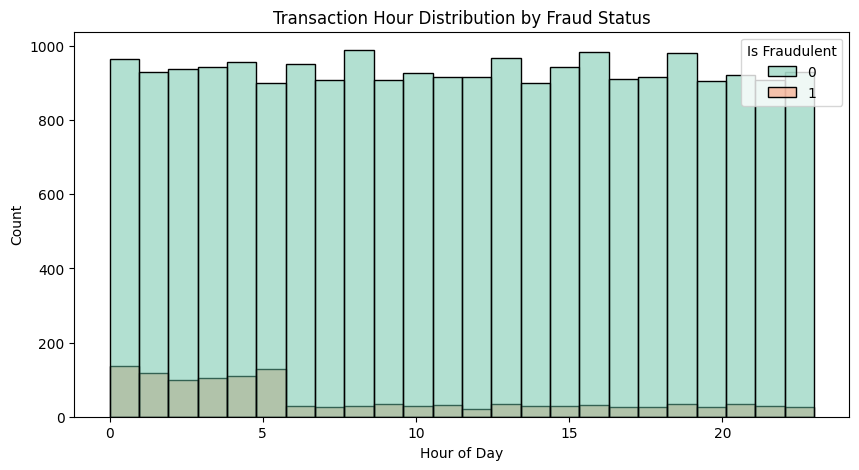

In [34]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_cleaned, x='Transaction Hour', hue='Is Fraudulent', bins=24, kde=False, palette='Set2')
plt.title('Transaction Hour Distribution by Fraud Status')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.show()


## Boxplot: Transaction Amount by Fraud Status

<ipython-input-35-158dd4210164>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cleaned, x='Is Fraudulent', y='Transaction Amount', palette='Pastel1')


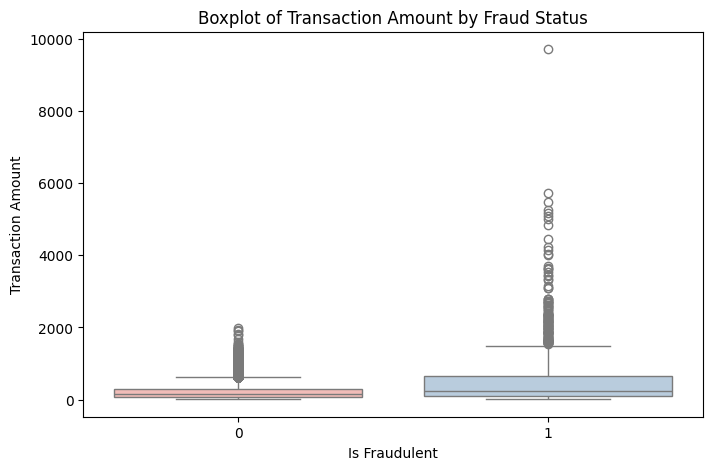

In [35]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_cleaned, x='Is Fraudulent', y='Transaction Amount', palette='Pastel1')
plt.title('Boxplot of Transaction Amount by Fraud Status')
plt.xlabel('Is Fraudulent')
plt.ylabel('Transaction Amount')
plt.show()


## Boxplot: Account Age Days by Fraud Status

<ipython-input-36-b2fafd6c7843>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cleaned, x='Is Fraudulent', y='Account Age Days', palette='coolwarm')


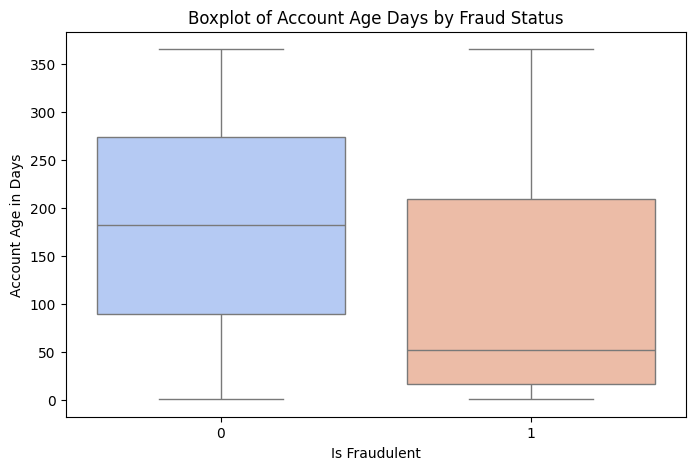

In [36]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_cleaned, x='Is Fraudulent', y='Account Age Days', palette='coolwarm')
plt.title('Boxplot of Account Age Days by Fraud Status')
plt.xlabel('Is Fraudulent')
plt.ylabel('Account Age in Days')
plt.show()


##  Correlation Heatmap (Numerical Features Only)

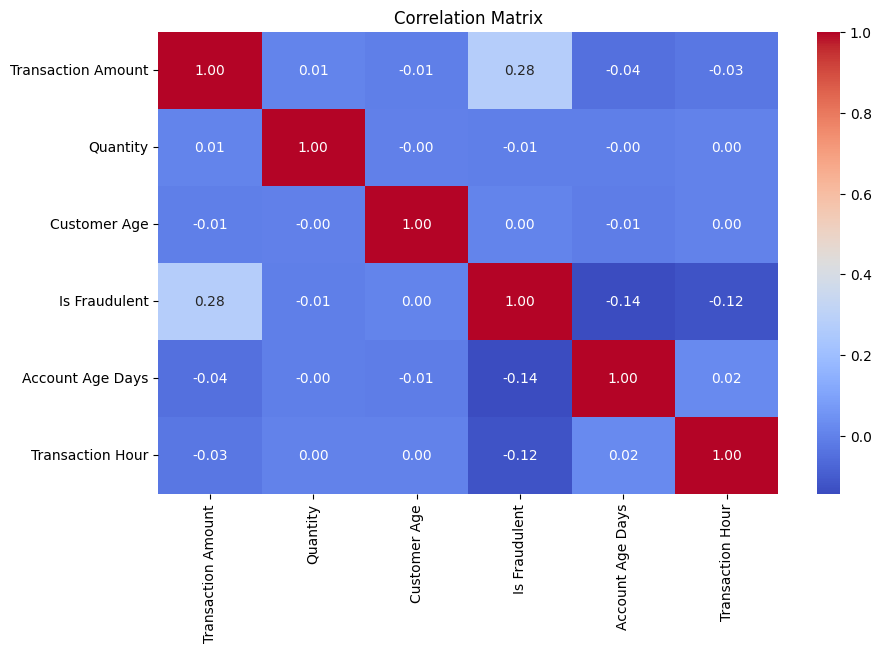

In [37]:
plt.figure(figsize=(10, 6))
corr_matrix = df_cleaned.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()




- Higher transaction amounts are associated with fraud
- Newer accounts are more likely to commit fraud
- Fraudulent transactions are more likely to occur at night
- Features like quantity, customer age, and transaction hour have low linear correlation with fraud status



# Q3

In [38]:
# Define bin edges
df_woe = df_cleaned.copy()

df_woe['Amt_Bin'] = pd.qcut(df_woe['Transaction Amount'], q=5, duplicates='drop')
df_woe['Acc_Age_Bin'] = pd.qcut(df_woe['Account Age Days'], q=5, duplicates='drop')

def compute_woe_iv(data, feature, target):
    df = data[[feature, target]].copy()
    grouped = df.groupby(feature)

    total_events = (df[target] == 1).sum()
    total_non_events = (df[target] == 0).sum()

    woe_df = pd.DataFrame()

    for val, group in grouped:
        events = (group[target] == 1).sum()
        non_events = (group[target] == 0).sum()

        rate_events = events / total_events if total_events != 0 else 0
        rate_non_events = non_events / total_non_events if total_non_events != 0 else 0

        woe = np.log(rate_events / rate_non_events) if rate_non_events > 0 and rate_events > 0 else 0
        iv = (rate_events - rate_non_events) * woe

        woe_df = pd.concat([woe_df, pd.DataFrame({
            'Bin': [val],
            'WOE': [woe],
            'IV': [iv],
            'Event Rate': [rate_events],
            'Non-Event Rate': [rate_non_events]
        })])

    total_iv = woe_df['IV'].sum()
    return woe_df.reset_index(drop=True), total_iv

# Compute WOE & IV for Transaction Amount bin
woe_amt, iv_amt = compute_woe_iv(df_woe, 'Amt_Bin', 'Is Fraudulent')
print("Transaction Amount IV:", iv_amt)

# Compute WOE & IV for Account Age Days bin
woe_acc_age, iv_acc_age = compute_woe_iv(df_woe, 'Acc_Age_Bin', 'Is Fraudulent')
print("Account Age IV:", iv_acc_age)




Transaction Amount IV: 0.26393016226521937
Account Age IV: 0.5350666242603692


<ipython-input-38-fa1e45891fb3>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(feature)
<ipython-input-38-fa1e45891fb3>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(feature)


In [39]:
def label_iv(iv):
    if iv < 0.02:
        return "Very Low"
    elif iv < 0.1:
        return "Weak"
    else:
        return "Strong"

print("Transaction Amount IV Label:", label_iv(iv_amt))
print("Account Age Days IV Label:", label_iv(iv_acc_age))


Transaction Amount IV Label: Strong
Account Age Days IV Label: Strong


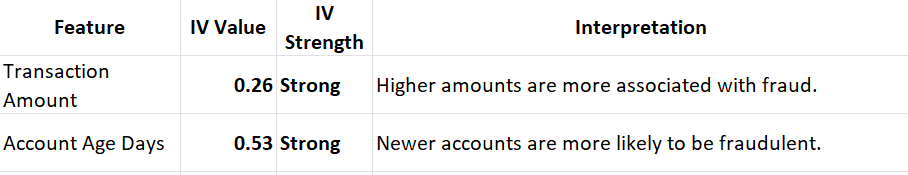

# Q4

In [44]:
# Recalculate WOE for 'Amt_Bin' and 'Acc_Age_Bin' columns
df_woe['Amt_Bin_WOE'] = df_woe['Amt_Bin'].map(woe_amt.set_index('Bin')['WOE'])
df_woe['Acc_Age_Bin_WOE'] = df_woe['Acc_Age_Bin'].map(woe_acc_age.set_index('Bin')['WOE'])

# Verify that the WOE columns are added to df_woe
print(df_woe.columns)

Index(['Transaction ID', 'Transaction Amount', 'Payment Method',
       'Product Category', 'Quantity', 'Customer Age', 'Device Used',
       'Is Fraudulent', 'Account Age Days', 'Transaction Hour', 'Amt_Bin',
       'Acc_Age_Bin', 'Amt_Bin_WOE', 'Acc_Age_Bin_WOE'],
      dtype='object')


In [46]:
# Add WOE columns to X_train and X_test
X_train_woe = X_train.copy()
X_test_woe = X_test.copy()

# Add the WOE columns to the features
X_train_woe = X_train.merge(df_woe[['Amt_Bin_WOE', 'Acc_Age_Bin_WOE']], left_index=True, right_index=True, how='left')
X_test_woe = X_test.merge(df_woe[['Amt_Bin_WOE', 'Acc_Age_Bin_WOE']], left_index=True, right_index=True, how='left')

# Select only the relevant columns for training
X_train_woe = X_train_woe[['Amt_Bin_WOE', 'Acc_Age_Bin_WOE', 'Transaction Hour']]
X_test_woe = X_test_woe[['Amt_Bin_WOE', 'Acc_Age_Bin_WOE', 'Transaction Hour']]

# Build and train the logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_woe, y_train)

# Predict on the test set
y_pred = model.predict(X_test_woe)

# Evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_woe)[:, 1])

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Interpret the model coefficients
coefficients = pd.DataFrame({
    'Feature': X_train_woe.columns,
    'Coefficient': model.coef_[0]
})
print("\nModel Coefficients:\n", coefficients)


Confusion Matrix:
 [[4483    0]
 [ 244    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      4483
           1       0.00      0.00      0.00       244

    accuracy                           0.95      4727
   macro avg       0.47      0.50      0.49      4727
weighted avg       0.90      0.95      0.92      4727


ROC AUC Score: 0.7958

Model Coefficients:
             Feature  Coefficient
0       Amt_Bin_WOE     0.947257
1   Acc_Age_Bin_WOE     0.932375
2  Transaction Hour    -0.077554


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Confusion Matrix:**
True Negatives (TN): 4483
False Positives (FP): 0
False Negatives (FN): 244
True Positives (TP): 0

This indicates that the model is not identifying any fraudulent transactions. It is classifying all transactions as non-fraudulent, resulting in a high number of false negatives

**Classification Report:**
- Precision for non-fraudulent: 0.95
- Recall for non-fraudulent: 1.00
- Precision for fraudulent: 0.00
- Recall for fraudulent: 0.00
- F1-Score for fraudulent: 0.00

The model fails to predict any fraudulent transactions and labels all transactions as legitimate.

**ROC AUC Score:**
The ROC AUC score of 0.7958 suggests that the model has some discriminatory power.

**Model Coefficients:**
- Amt_Bin_WOE (WOE for Transaction Amount): Indicates that higher amounts increase the likelihood of a transaction being fraudulent
- Acc_Age_Bin_WOE (WOE for Account Age): Indicates that more recent accounts may have a higher likelihood of fraudulent behavior
- Transaction Hour: Indicates that certain hours might decrease the likelihood of fraud

# Q5

## Decision Tree Classifier:

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Hyperparameter grid for tuning
param_grid_dt = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search to find the best parameters
grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt, cv=3, n_jobs=-1, verbose=2)
grid_search_dt.fit(X_train_woe, y_train)

# Get the best model
best_dt_model = grid_search_dt.best_estimator_

# Predict and evaluate
y_pred_dt = best_dt_model.predict(X_test_woe)

# Evaluation
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print("\nDecision Tree Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

print(f"\nDecision Tree ROC AUC Score: {roc_auc_score(y_test, best_dt_model.predict_proba(X_test_woe)[:, 1]):.4f}")


Fitting 3 folds for each of 36 candidates, totalling 108 fits

Decision Tree Confusion Matrix:
[[4483    0]
 [ 244    0]]

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4483
           1       0.00      0.00      0.00       244

    accuracy                           0.95      4727
   macro avg       0.47      0.50      0.49      4727
weighted avg       0.90      0.95      0.92      4727


Decision Tree ROC AUC Score: 0.7914


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Support Vector Machine (SVM):

In [49]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Initialize the SVM model
svm_model = SVC(probability=True, random_state=42)

# Smaller hyperparameter grid for tuning
param_grid_svm = {
    'C': [0.1, 1],
    'gamma': ['scale'],
    'kernel': ['linear']
}

# Perform grid search to find the best parameters
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid_svm, cv=3, n_jobs=-1, verbose=2)
grid_search_svm.fit(X_train_woe, y_train)

# Get the best model
best_svm_model = grid_search_svm.best_estimator_

# Predict and evaluate
y_pred_svm = best_svm_model.predict(X_test_woe)

# Evaluation
print("\nSVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

print(f"\nSVM ROC AUC Score: {roc_auc_score(y_test, best_svm_model.predict_proba(X_test_woe)[:, 1]):.4f}")


Fitting 3 folds for each of 2 candidates, totalling 6 fits

SVM Confusion Matrix:
[[4483    0]
 [ 244    0]]

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4483
           1       0.00      0.00      0.00       244

    accuracy                           0.95      4727
   macro avg       0.47      0.50      0.49      4727
weighted avg       0.90      0.95      0.92      4727


SVM ROC AUC Score: 0.3907


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [50]:
# Summary of performance
models = ['Logistic Regression', 'Decision Tree', 'SVM']
roc_auc_scores = [roc_auc,  # Logistic Regression ROC AUC Score
                  roc_auc_score(y_test, best_dt_model.predict_proba(X_test_woe)[:, 1]),  # Decision Tree ROC AUC Score
                  roc_auc_score(y_test, best_svm_model.predict_proba(X_test_woe)[:, 1])]  # SVM ROC AUC Score

# Show the ROC AUC scores
for model, score in zip(models, roc_auc_scores):
    print(f"{model} ROC AUC Score: {score:.4f}")

# Based on these, recommend the best model (e.g., the one with the highest ROC AUC score)


Logistic Regression ROC AUC Score: 0.7958
Decision Tree ROC AUC Score: 0.7914
SVM ROC AUC Score: 0.3907


Logistic Regression is the best performing model based on the ROC AUC score on the test data. It has the highest ROC AUC score (0.7958), indicating better performance in distinguishing between fraudulent and non-fraudulent transactions compared to the other models.

# Q6

In [54]:
# Ensure that the model is LogisticRegression
from sklearn.linear_model import LogisticRegression

# Check if the model is a LogisticRegression instance
if not isinstance(model, LogisticRegression):
    print("Warning: The model is not a LogisticRegression instance. Reinitializing.")
    model = LogisticRegression(random_state=42)
    model.fit(X_train_woe, y_train)  # Refit the model if necessary

# Now proceed with threshold calculations
def calculate_costs(y_true, y_prob, threshold, transaction_data):
    # Predict fraud (1) or legitimate (0) based on the threshold
    y_pred = (y_prob >= threshold).astype(int)

    # Get the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # FN Cost (fraud loss)
    fn_cost = np.sum(transaction_data.loc[y_pred == 0, 'Transaction Amount'])

    # FP Cost (5% of total transaction amount + CAC per customer)
    fp_cost = (np.sum(transaction_data.loc[y_pred == 1, 'Transaction Amount']) * 0.05) + (fp * 15)

    # Total Cost
    total_cost = fn_cost + fp_cost

    return fn_cost, fp_cost, total_cost

# Calculate for different thresholds
thresholds = [0.3, 0.5, 0.7]
results = []

# Ensure `model` is available and trained
if model is not None:
    for threshold in thresholds:
        fn_cost, fp_cost, total_cost = calculate_costs(y_test, model.predict_proba(X_test_woe)[:, 1], threshold, X_test)
        results.append([threshold, fn_cost, fp_cost, total_cost])

    # Convert results into a DataFrame for better visualization
    cost_df = pd.DataFrame(results, columns=['Threshold', 'FN Cost', 'FP Cost', 'Total Cost'])
    print(cost_df)
else:
    print("Model is not available.")


   Threshold     FN Cost    FP Cost    Total Cost
0        0.3  1034820.58  4773.3255  1.039594e+06
1        0.5  1116787.09     0.0000  1.116787e+06
2        0.7  1116787.09     0.0000  1.116787e+06


At a threshold of 0.3: The FN cost is the lowest among the thresholds, indicating that fewer fraud cases are missed. While the FP cost is higher at this threshold, the trade-off is acceptable if the main priority is capturing all fraud.

At a threshold of 0.5 and 0.7: The FN cost increases, which means more fraud transactions are missed as the model becomes more conservative in classifying fraud. The FP cost is lower, but this comes at the expense of catching fewer fraud cases.

If we prioritizing catching all fraud cases, we should choose the lowest threshold (0.3).

# Q7

In [57]:
Threshold = 0.3

# Get predicted probabilities from logistic regression model
pred_probs = model.predict_proba(X_test_woe)[:, 1]

# Predict based on the threshold
y_pred = (pred_probs >= threshold).astype(int)

# Calculate False Negatives (FN) and False Positives (FP)
fn = ((y_test == 1) & (y_pred == 0))  # Fraud cases predicted as non-fraud
fp = ((y_test == 0) & (y_pred == 1))  # Non-fraud cases predicted as fraud

# alculate FN and FP costs
fn_cost = np.sum(fn * df_woe.loc[fn.index, 'Transaction Amount'])  # Fraud loss
fp_cost = np.sum(fp * (0.05 * df_woe.loc[fp.index, 'Transaction Amount'] + 15))  # 5% profit loss + $15 CAC

# Total Cost
total_cost = fn_cost + fp_cost

# Print the costs
print(f"False Negative Cost: ${fn_cost:,.2f}")
print(f"False Positive Cost: ${fp_cost:,.2f}")
print(f"Total Cost: ${total_cost:,.2f}")

# Calculate baseline cost (predicting everything as legitimate → all frauds missed)
baseline_fn = y_test == 1  # All frauds missed
baseline_cost = df_woe.loc[baseline_fn.index, 'Transaction Amount'][baseline_fn].sum()

# Summary Table
summary_table = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression with Best Threshold'],
    'Total Cost': [baseline_cost, total_cost]
})

print("\nSummary of Model Costs:")
print(summary_table)


False Negative Cost: $100,099.56
False Positive Cost: $1,943.91
Total Cost: $102,043.47

Summary of Model Costs:
                                     Model  Total Cost
0                                 Baseline   156687.87
1  Logistic Regression with Best Threshold   102043.47


# Q8

In [59]:
# Predict probabilities and apply best threshold
y_probs = model.predict_proba(X_test_woe)[:, 1]
y_pred_thresh = (y_probs >= 0.3).astype(int)

# Confusion matrix components
TP_mask = (y_test == 1) & (y_pred_thresh == 1)
TN_mask = (y_test == 0) & (y_pred_thresh == 0)
FP_mask = (y_test == 0) & (y_pred_thresh == 1)
FN_mask = (y_test == 1) & (y_pred_thresh == 0)

# False Negatives (FN): missed frauds → fraud loss
fn_cost = df_woe.loc[FN_mask.index, 'Transaction Amount'][FN_mask].sum()

# False Positives (FP): 5% lost profit + $15 CAC
fp_loss = df_woe.loc[FP_mask.index, 'Transaction Amount'][FP_mask] * 0.05 + 15
fp_cost = fp_loss.sum()

# True Positives (TP): prevented fraud loss
tp_benefit = df_woe.loc[TP_mask.index, 'Transaction Amount'][TP_mask].sum()

# True Negatives (TN): 5% profit on legitimate transactions
tn_benefit = df_woe.loc[TN_mask.index, 'Transaction Amount'][TN_mask] * 0.05
tn_benefit = tn_benefit.sum()

total_utility = (tp_benefit + tn_benefit) - (fn_cost + fp_cost)

# Ownership cost
ownership_cost = 30000 + 20000  # acquisition + operation

# Fraud handling costs
inspection_cost = 200 * y_pred_thresh.sum()  # all predicted fraud
handling_cost = 300 * TP_mask.sum()          # actual fraud caught
legal_cost = 500                              # flat

fraud_handling_cost = inspection_cost + handling_cost + legal_cost

roi = total_utility / (ownership_cost + fraud_handling_cost) * 100

print("==== ROI Evaluation ====")
print(f"True Positives Benefit: ${tp_benefit:,.2f}")
print(f"True Negatives Benefit: ${tn_benefit:,.2f}")
print(f"False Negatives Cost:  ${fn_cost:,.2f}")
print(f"False Positives Cost:  ${fp_cost:,.2f}")
print(f"Total Utility:         ${total_utility:,.2f}\n")

print(f"Ownership Cost:        ${ownership_cost:,.2f}")
print(f"Fraud Handling Cost:   ${fraud_handling_cost:,.2f}")
print(f"ROI:                   {roi:.2f}%")


==== ROI Evaluation ====
True Positives Benefit: $56,588.31
True Negatives Benefit: $46,736.05
False Negatives Cost:  $100,099.56
False Positives Cost:  $1,943.91
Total Utility:         $1,280.89

Ownership Cost:        $50,000.00
Fraud Handling Cost:   $25,500.00
ROI:                   1.70%


Although the ROI is positive (1.70%), it's fairly low, meaning the model is barely covering its total investment and fraud handling costs.